# Funciones para detección de espiguletas (*spiklets*)

Este cuaderno contiene funciones, graficas y pruebas para la detección automática de espiguletas.
Empezamos por cargar las bibliotecas necesarias de uso general.

In [1]:
using PyPlot, HDF5
using Statistics

El archivo adjunto **sacadatos.jl** contiene funciones para abrir y ordenar un archivo tipo *hdf5* del programa *Stimfit*.

In [71]:
include("sacadatos.jl")

devuelvedatos (generic function with 1 method)

In [102]:
nomine = "../h5files/Bianca Files/88101654.hf5"

"../h5files/Bianca Files/88101654.hf5"

In [103]:
datos = h5open(nomine, "r");
names(datos)

4-element Array{String,1}:
 "ch0"        
 "channels"   
 "comment"    
 "description"

In [104]:
constantes, sweps = devuelvedatos(datos, "ch0");
const freq=1/constantes[1];
println("la frequencia de muestreo es ", freq, " kHz." )

la descripcion de tus barridas de datos son las siguientes
HDF5.HDF5Compound{3}[HDF5Compound{3}((0.1, "ms", "mV"), ("dt", "xunits", "yunits"), (Float64, String, String))]
la frequencia de muestreo es 10.0 kHz.


In [105]:
const prevGms=10
const postGms=40
const preG=round(Int, prevGms*freq)
const posG=round(Int, postGms*freq)

400

Funciones auxiliares para convertir tiempo (en ms) a intervalos (en indices enteros) y viceversa:

In [106]:
function iart(i::Int,f::Int) 
  #  """function que pasa de intervalos enteros a tiempo en ms"""
aux=i:f
    result=aux./freq
end

function tari(it,ft)
    # funtion que pasa de tiempo en ms a intervalos enteros de indices
    auxi=round(Int, it*freq)
    auxf=round(Int, ft*freq)
    result=auxi:auxf
end

derivadadt(xx::Array, f=freq)=diff(xx).*f

derivadadt (generic function with 2 methods)

Funciones de suavizado (duro y gaussiano), e.g. $ \tilde{x}= \sum_{-2}^{2} x_i /N$

In [107]:
function suaveduro(trazo::Array, nv=9)
# funcion que promedia cada punto sobre sus vecinos
    aux=trazo
    l=length(trazo)
    cabeza=repeat([trazo[1]],nv)
    cola=repeat([trazo[end]],nv)
    aux=vcat(cabeza,aux,cola)
    result=zeros(l)
    for j=1:l
        result[j]=mean(aux[j:j+nv*2])
    end
    return result 
end


gauss(x, sigma)=exp(-(x/sigma)^2/2)

function pesosgauss(desv::Real,n::Int)
# funcion que promedia cada punto sobre sus vecinos, pero con peso gaussiano
    g=zeros(2*n+1)
    for j=-n:n
        g[j+n+1]=gauss(j,desv)
    end
    return g
end
        
function suavegauss(trazo::Array, nv=10)
    aux=trazo
    pesos=pesosgauss(nv/2,nv)
    pesoT=sum(pesos)
    l=length(trazo)
    cabeza=repeat([trazo[1]],nv)
    cola=repeat([trazo[end]],nv)
    aux=vcat(cabeza,aux,cola)
    result=zeros(l)
    for j=1:l
        for k=0:2*nv
        result[j]+=aux[j+k]*pesos[k+1]
        end
    end
    result/=pesoT
    return result 
end

suavegauss (generic function with 2 methods)

La siguiente funcion, **intervalosP**, determina, a partir de la derivada suavizada de un trazo, los intervalos donde posiblemente hay una espiguleta o una espiga, es decir, aquellos cuya derivada es mayor a cierto umbral. 

In [108]:
umbralinf=0.06*freq
umbralsup=0.5*freq

function intervalosP(dtrazo::Array,thres=umbralinf, thres2=umbralsup)
    # recuerdese: dtrazo es la DERIVADA del trazo suavizado, no el trazo.
    #se recomienda usar una diferencia suavizada en dtrazo
    esunbrinco(x)=  x>thres 
    escontiguo(x,y)=(y-x)==1
    result=Dict{Int, Any}()
    preresult=Dict{Int, Array}()
    
    #=
    Este primer loop encuentra los intervalos
    de INDICES contiguos que cumplen estar
    por encima del umbral
    =#
    r=findall(esunbrinco,dtrazo)
    
    if !(isempty(r))
        k=1
        preresult[1]=[]
        for j=1:length(r)-1   
            if escontiguo(r[j], r[j+1])
                push!(preresult[k], r[j+1])
            else
                k+=1
                preresult[k]=[]
            end
         end 
    
        n=length(keys(preresult))
        
    else 
        println("no hay naaaaaada en la seccion")
    end
    
    tamanointervalo=length(dtrazo)
   
    #=
    A partir del diccionario obtenido en el loop anterior:
    1) Buscamos el maximo
    2) Vemos si su valor esta debajo del segundo umbral
    3) si si, procedemos a localizar su posicion en la lista ORIGINAL de datos
    4) devolvemos una lista con todos los numeritos en ese rango de 200 antes a 800 despues
    =#
     n=length(keys(preresult))
    if n>0    
    for j in keys(preresult)
        aux=preresult[j]
        (a, lugarlista) =findmax(dtrazo[aux[1]:aux[end]])
          #  println(aux)
        if a<thres2
            lugarreal=aux[lugarlista]
            ai=lugarreal-preG
            af=lugarreal+posG
            (ai<1) ? ai=1 : ai=ai
            (af>tamanointervalo) ? af=tamanointervalo : af=af
            (maximototal, b)=findmax(dtrazo[ai:af])  
            println("vamos bien, ", ai, " ", af, " ", maximototal)
         
            if maximototal<thres2
                result[j]=ai:af
            end
                
                end # Este cierra el a<thres2 .
        
    end
    
    else
       # println(" te dije que no hay naaaada")
    end
    
    return result
end

intervalosP (generic function with 3 methods)

In [109]:
g0(xs::Array ,d1=-71)= xs.-(xs[1]+d1) #funcion que normaliza al valor d1

g0 (generic function with 2 methods)

In [110]:
function average1(data::Dict)
    aux=0
    k=0
    for subs in keys(data)
        for j in keys(data[subs])
            rango=data[subs][j]
            valor=suaves[subs][rango]
            aux=aux.+valor
            k+=1
        end
    end
    result=aux./k
end

average1 (generic function with 1 method)

In [111]:
function risetime(derivada::Array, thresmin=0.25)
    pasaumbral(x)= x > thresmin
    esnegativa(x) = sign(x)==-1
    
    aux1=findfirst(pasaumbral, derivada)
    aux2=findfirst(esnegativa, derivada[aux1:end])
    aux2=aux2+aux1
    result=(aux1, aux2)

end


risetime (generic function with 2 methods)

In [112]:
sign(-20.1)==-1

true

In [113]:
function separamochas(datos::Dict)
    
Limpias=Dict{String,Dict}()
Mochas=Dict{String,Dict}()
longi=preG+posG+1
    
    for subs in keys(datos)
    for j in keys(datos[subs])
        Limpias[subs]=Dict{Int, Array}()
        Mochas[subs]=Dict{Int, Array}()     
        if length(datos[subs][j])==longi
            Limpias[subs][j]=datos[subs][j]
        else
            Mochas[subs][j]=datos[subs][j]
        end
       
        if isempty(Limpias[subs])
            delete!(Limpias, subs)
        end
        
        if isempty(Mochas[subs])
            delete!(Mochas, subs)
        end
       
    end
end

result=(Limpias, Mochas)
end

separamochas (generic function with 1 method)

# A partir de aquí viene la numérica sucia: vamos a cargar todos los intervalos de un segundo que a ojo de buen cubero tienen una espiguelta.

In [114]:
sospechosas=[14,16,18,24,28,30,41,44]
ksuspect=[]
subs="section_"
for s in sospechosas
    aux=subs*"$s"
    push!(ksuspect, aux)
end
push!(ksuspect, "section_01")
push!(ksuspect, "section_02")
push!(ksuspect, "section_46")
push!(ksuspect, "section_47")
todas=keys(sweps);

In [115]:
suaves=Dict{String, Array}()
derivadas=Dict{String, Array}()
for subs in todas # aqui estaba ksuspect que era la prueba de las conocidas
    suaves[subs]=suavegauss(sweps[subs])
    derivadas[subs]=derivadadt(suaves[subs])
    
end


In [116]:
derivadas

Dict{String,Array} with 50 entries:
  "section_44" => [-0.111622, -0.105151, -0.140798, -0.161237, -0.178414, -0.21…
  "section_06" => [-0.0394251, -0.0567586, -0.0619136, -0.0693103, -0.0525113, …
  "section_13" => [0.12721, 0.113392, 0.11036, 0.0507621, 0.0450304, 0.0274923,…
  "section_17" => [-0.226291, -0.226359, -0.187572, -0.153338, -0.125898, -0.09…
  "section_12" => [0.258527, 0.256587, 0.227386, 0.193115, 0.173372, 0.146704, …
  "section_41" => [0.0977322, 0.0763593, 0.0442755, 0.0164756, -0.00568299, -0.…
  "section_16" => [0.0548492, 0.0626434, 0.0554938, 0.054392, 0.0216062, 0.0279…
  "section_09" => [0.116259, 0.0937374, 0.0836923, 0.055489, 0.0601895, 0.02499…
  "section_07" => [-0.0352487, -0.049249, -0.0654431, -0.0691607, -0.0738839, -…
  "section_43" => [-0.0211423, -0.0877299, -0.131395, -0.169723, -0.23067, -0.2…
  "section_29" => [-0.0827289, -0.0894814, -0.109598, -0.12053, -0.143973, -0.1…
  "section_39" => [-0.177061, -0.14187, -0.110197, -0.103525, -0.103291, 

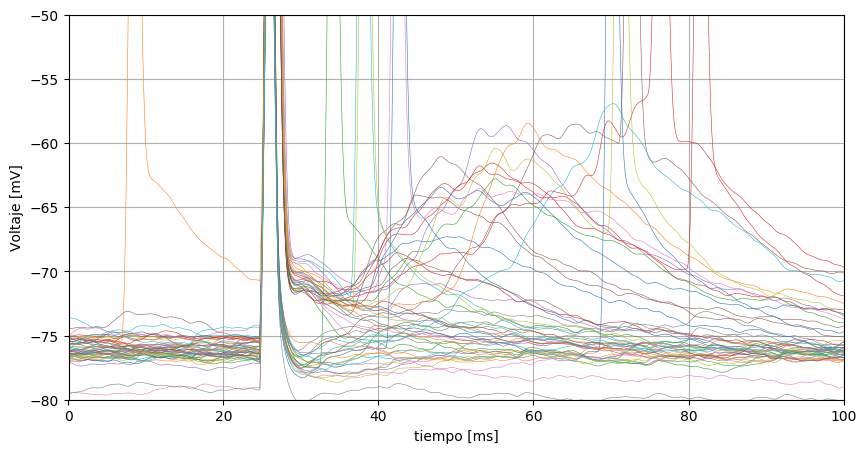

In [139]:
figura=figure(figsize=(10,5))
for subs in keys(suaves)
    lala=length(suaves[subs])
rangot=iart(1, lala)  
 plot(rangot,suaves[subs], label=subs, lw=0.4)
end
ylim(-80, -50)
xlim(0.01, 100)
xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
#legend()
grid()

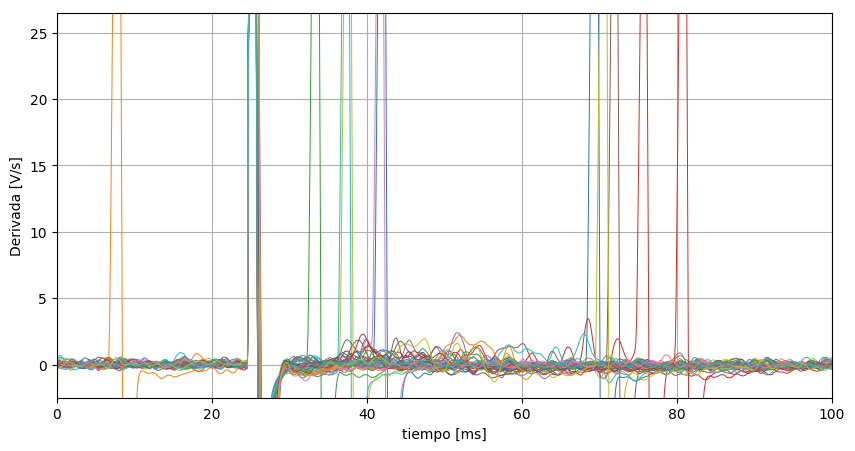

In [141]:
figura=figure(figsize=(10,5))
ylim(-2.5, 26.5)
xlim(0.01, 100)

for subs in keys(derivadas)
lala=length(derivadas[subs])
rangot=iart(1, lala)    
 plot(rangot,derivadas[subs], label=subs, lw=0.7)
end
xlabel("tiempo [ms]")
ylabel("Derivada [V/s]")
#legend()
grid()

In [119]:
length(rangot), lala

UndefVarError: UndefVarError: rangot not defined

In [123]:
intSS=Dict{String,Dict}()  #intSS es subintervalo del intervalo
for subs in keys(derivadas)
    println(subs)
 intSS[subs]=intervalosP(derivadas[subs], 0.06*freq, 0.4*freq)
end

section_44
vamos bien, 227 727 60.3257226067597


BoundsError: BoundsError: attempt to access 0-element Array{Any,1} at index [1]

In [124]:
intSS

Dict{String,Dict} with 0 entries

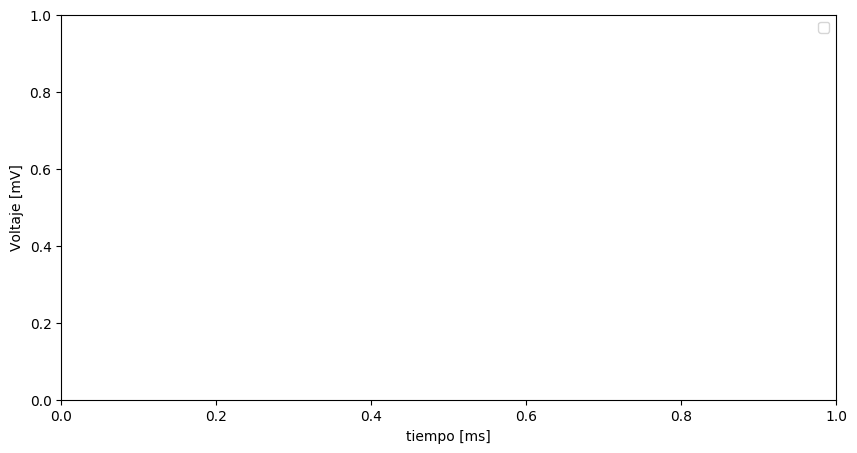

No handles with labels found to put in legend.


PyObject <matplotlib.legend.Legend object at 0x7f46a0c29cc0>

In [125]:
figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(intSS)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(intSS[subs])
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll)
        plot(rangot,suaves[subs][rango], label=subs)
    end
end


xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
legend()

In [126]:
figura=figure(figsize=(10,5))
xlim(13000,14000)
#ylim(-0.02,0.1)
  #rango=intSS[subs][1]
plot(derivadas["section_50"])
#plot(suaves["section_50"])

KeyError: KeyError: key "section_50" not found

In [127]:
(limpia, mocha)=separamochas(intSS);

In [128]:
a=average1(limpia);

In [129]:
normCut=Dict{String,Dict}()
    
for subs in keys(limpia)
    normCut[subs]=Dict{Int, Array}()
    for j in keys(limpia[subs])
         arre=intSS[subs][j]
        # es mejor dibujar con rangos que con listas de numeros
        rango=arre[1]:arre[end]
        normCut[subs][j]=suaves[subs][rango].-(suaves[subs][rango][1]-a[1])
    end
end

In [130]:
normCut

Dict{String,Dict} with 0 entries

In [131]:
mocha

Dict{String,Dict} with 0 entries

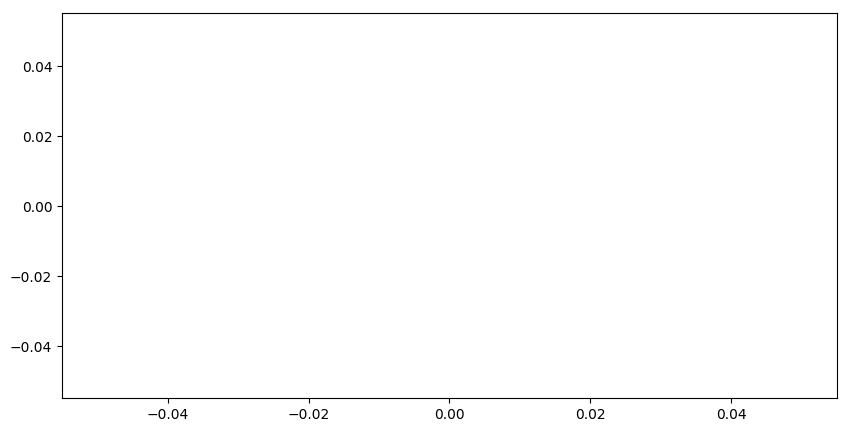

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f467d4cbd30>

In [132]:
figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(normCut)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(normCut[subs])
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        plot(normCut[subs][j])
    end
end

plot(a, lw=3)

**NOTA para avanzar**

En la grafica superior, la linea gruesa es el promedio. Nos interesa calcular el tiempo que le lleva levantarse desde
el cambio en la curvatura (suave a muy empinado) hasta el máximo punto de la funcion.

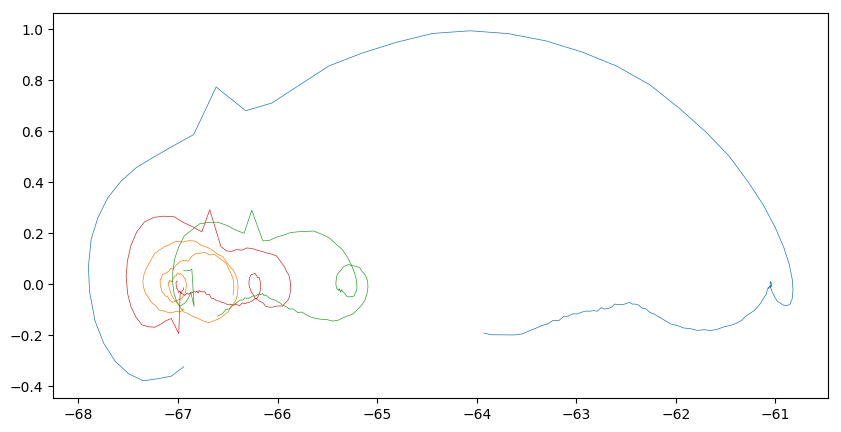

In [93]:

figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(limpia)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(limpia[subs])
        # tomamos el rango de cada subintervalo sospechoso
        arre=limpia[subs][j]
        # es mejor dibujar con rangos que con listas de numeros
        rango=arre[1]:arre[end]
        plot(suaves[subs][rango].-(suaves[subs][rango][1]-a[1]), derivadas[subs][rango], lw=0.5)
    end
end
#plot(promSpK[2:end],difProm, lw=5, c="red")

In [94]:
Mochas

UndefVarError: UndefVarError: Mochas not defined

In [95]:
promSpK=a

131-element Array{Float64,1}:
 -66.94157141011317
 -66.9782149100577 
 -67.02044894064481
 -67.06353395745285
 -67.10867741666152
 -67.15081233608517
 -67.21695057486588
 -67.26503075518386
 -67.30465300332263
 -67.33491872027322
 -67.35696450746386
 -67.36779156914663
 -67.3698234143505 
   ⋮               
 -65.78538670130177
 -65.79596303064866
 -65.8071232228461 
 -65.81836058665954
 -65.83306759358028
 -65.84838645734763
 -65.86628373042062
 -65.88732352827515
 -65.91077415953711
 -65.93624543637952
 -65.96363012729107
 -65.99479617451125

In [96]:
riset=risetime(difProm)

(24, 47)

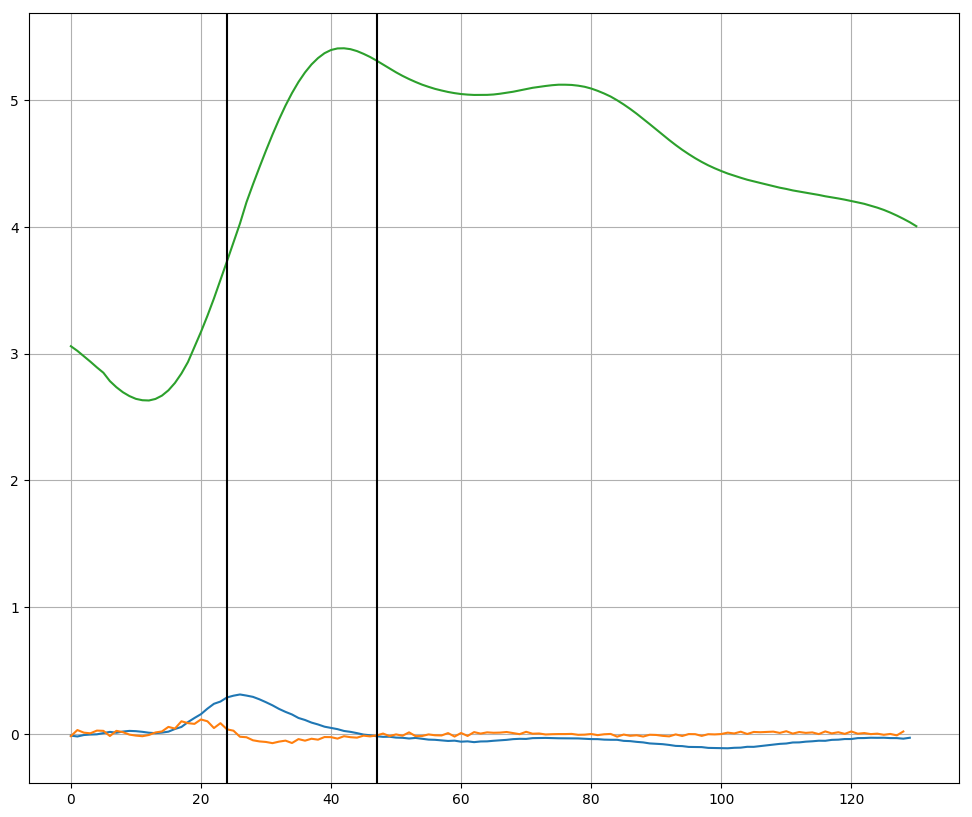

In [97]:
#plot(promSpK)
figure(figsize=(12,10))
plot(difProm)
plot(ddprom)
plot(promSpK.+70)
axvline(x=riset[1], c="black")
axvline(x=riset[2], c="black")

grid()

In [98]:
(riset[2]-riset[1])/freq

8.832

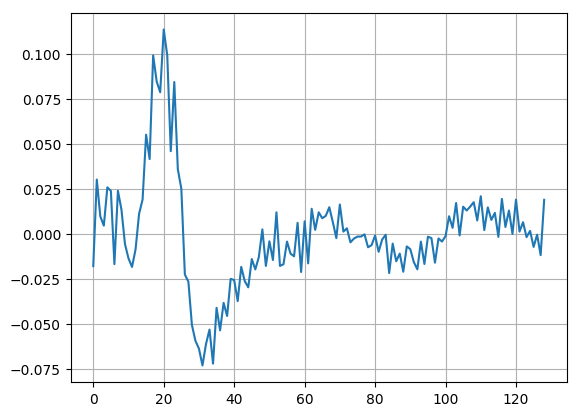

In [99]:
plot(ddprom)
grid()

In [100]:
difProm=derivadadt(promSpK)
ddprom=derivadadt(difProm)

129-element Array{Float64,1}:
 -0.03791321236557704  
 -0.005771119662307163 
 -0.013959705950511898 
  0.020402966207062296 
 -0.1627829274974494   
  0.12246404664935914  
  0.057359023567789526 
  0.06345303811424902  
  0.05574496636257668  
  0.07608185158867402  
  0.059646379115814746 
  0.09567571972709998  
  0.09592697484759001  
  ⋮                    
 -0.006079909116865003 
 -0.00690374205921986  
 -0.003959573367968983 
 -0.0005233535156172012
 -0.023530023242924553 
 -0.004149419803898028 
 -0.017485957205143027 
 -0.021311610117850467 
 -0.016349510412858183 
 -0.013703379858697682 
 -0.012976169631187362 
 -0.025643963681613275 

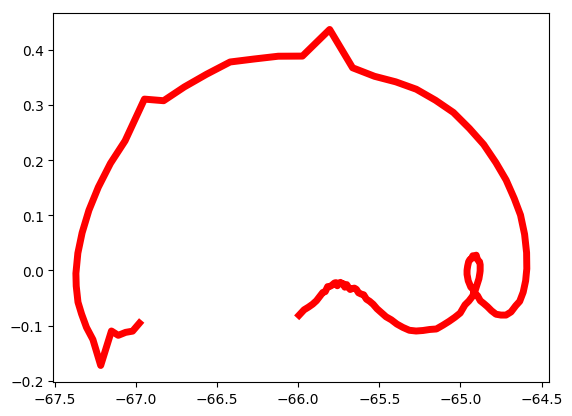

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f467edc0e80>

In [101]:
plot(promSpK[2:end],difProm, lw=5, c="red")

## A partir de aquí estamos guardando datos

In [ ]:
using DelimitedFiles

In [ ]:
datos=hcat(promSpK[2:end],difProm)

In [ ]:
writedlm("../h5files/masterspikelet.dat", datos)

In [ ]:
nota="Esta espiguleta es el promedio de todas las detectadas automaticamente con el experimento  "*nomine

In [ ]:
h5open("../h5files/masterspiklet.h5", "w") do file
   write(file, "voltaje", promSpK[2:end])  # alternatively, say "@write file A"
    write(file, "derivative", difProm)  # alternatively, say "@write file A"
    write(file, "nota", nota)  # alternatively, say "@write file A"
end


In [ ]:

test = h5open("../h5files/masterspiklet.h5", "r");
names(test)

In [ ]:
#using HDF5